In [16]:
import pandas as pd
import numpy as np
import math

from dataclasses import dataclass
from typing import Any, List, Tuple, Dict
from pandas import DataFrame

@dataclass
class City:
    index : int
    X : float
    Y : float

@dataclass
class Item:
    index : int
    Profit : int
    Weight : int
    Node : int

@dataclass
class TTP:
    Name :str = None
    DTYPE : str = None
    Dimension : int = 0
    ITEMS : int = 0
    CAPACITY : int = 0
    MIN_SPEED : float = 0
    MAX_SPEED : float = 0
    RENTING_RATIO : float = 0
    EDGE_W : str = None
    NODE : List[City] = None
    ITEM : List[Item] = None


def read_problem(file_path:str):
    with open(file_path,'r') as file:
        lines = file.readlines()
    
    data = TTP(NODE=[],ITEM=[])
    
    for i , line in enumerate(lines):
        if line.startswith("PROBLEM NAME"):
            data.Name = line.split(':')[-1].strip()
        elif line.startswith("KNAPSACK DATA TYPE"):
            data.DTYPE = line.split(':')[-1].strip()
        elif line.startswith("DIMENSION"):
            data.Dimension = int(line.split(':')[-1].strip())
        elif line.startswith("NUMBER OF ITEMS"):
            data.ITEMS = int(line.split(':')[-1].strip())
        elif line.startswith("CAPACITY OF KNAPSACK"):
            data.CAPACITY = int(line.split(':')[-1].strip())
        elif line.startswith("MIN SPEED"):
            data.MIN_SPEED = float(line.split(':')[-1].strip())
        elif line.startswith("MAX SPEED"):
            data.MAX_SPEED = float(line.split(':')[-1].strip())
        elif line.startswith("RENTING RATIO"):
            data.RENTING_RATIO = float(line.split(':')[-1].strip())
        elif line.startswith("EDGE_WEIGHT_TYPE"):
            data.EDGE_W = line.split(':')[-1].strip()
        elif line.startswith("NODE_COORD_SECTION"):
            for j in range(1,data.Dimension+1):
                node = lines[i+j].split()
                data.NODE.append(City(index=int(node[0]),X=float(node[1]),Y=float(node[2])))
        elif line.startswith("ITEMS SECTION"):
            for j in range(1,data.ITEMS+1):
                item = lines[i+j].split()
                data.ITEM.append(
                    Item(int(item[0]),int(item[1]),int(item[2]),int(item[3]))
                )
        else:
            pass
    
    return data

def generate_ttp_solution(number_of_cities: int, items: List[Item], knapsack_capacity: int) -> Tuple[List[int], List[int]]:
    # Generate a random path (tour)
    path = np.random.permutation(number_of_cities) + 1

    # Initialize knapsack plan with no items picked
    plan = [0] * len(items)
    current_weight = 0

    # Randomly decide to pick up items considering the knapsack capacity
    for i, item in enumerate(items):
        item_weight = item.Weight
        if current_weight + item_weight <= knapsack_capacity:
            decision = np.random.choice([0, 1])
            plan[i] = decision
            current_weight += item_weight * decision

    return path.tolist(), plan

def euclidean_distance(p1: Tuple[float, float], p2: Tuple[float, float]) -> float:
    return math.ceil(np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2))


In [17]:
def calculate_time_and_profit(solution: List[int], plan: List[int], nodes: List[City], items: List[Item], min_speed, max_speed, max_weight):
    total_time = 0
    total_profit = 0
    current_weight = 0

    # Calculate the total travel time
    for i in range(len(solution)):
        current_city_index = solution[i]
        next_city_index = solution[0] if i == len(solution) - 1 else solution[i + 1]

        current_city = nodes[current_city_index - 1]
        next_city = nodes[next_city_index - 1]

        

        # Update current weight based on items picked at the current city
        for item, is_picked in zip(items, plan):
            if is_picked and item.Node == current_city_index:
                current_weight += item.Weight

        # Calculate speed based on current weight
        speed = max_speed - (current_weight / max_weight) * (max_speed - min_speed)
        speed = max(speed, min_speed)  # Ensure speed doesn't drop below minimum

        # Distance between current city and next city
        distance = euclidean_distance((current_city.X, current_city.Y), (next_city.X, next_city.Y))

        # Update time with time to next city
        total_time += distance / speed

        if current_weight > max_weight:
            return np.Inf , 0.0

    # Calculate total profit from picked items
    for item, is_picked in zip(items, plan):
        if is_picked:
            total_profit += item.Profit


    return total_time, total_profit

@dataclass
class Solution:
    path : List[int]
    plan : List[int]

In [18]:
path = './datasets/test-example-n4.txt'
data = read_problem(path)

In [66]:
MAX_SPEED = data.MAX_SPEED
MIN_SPEED = data.MIN_SPEED
RENTING_RATIO = data.RENTING_RATIO
CAPACITY = data.CAPACITY
NODE = data.NODE
ITEM = data.ITEM

@dataclass
class Fitness:
    time: float
    profit: float
    net_profit: float

@dataclass
class Particle:
    path: List[int]
    plan: List[int]
    current_score: Fitness = None
    velocity: List = None  # Represented as a change in path and plan
    personal_best_path: List[int] = None
    personal_best_plan: List[int] = None
    personal_best_score: Fitness = None

    def __post_init__(self):
        self.velocity = self.velocity if self.velocity is not None else []
        self.calculate_and_update_score()
        self.personal_best_path = self.path.copy() if self.personal_best_path is None else self.personal_best_path
        self.personal_best_plan = self.plan.copy() if self.personal_best_plan is None else self.personal_best_plan

    def clear_velocity(self):
        self.velocity.clear()

    def calculate_and_update_score(self):
        time, profit, net_profit = self.calculate_score(self.path, self.plan)
        self.current_score = Fitness(time, profit, net_profit)
        if not self.personal_best_score:
            self.personal_best_score = self.current_score
        # Update personal best if the current score is better
        if self.current_score.net_profit > self.personal_best_score.net_profit:
            self.update_personal_best()

    def update_personal_best(self):
        self.personal_best_path = self.path.copy()
        self.personal_best_plan = self.plan.copy()
        self.personal_best_score = self.current_score.net_profit

    def calculate_score(self, path, plan):
        # Assuming calculate_time_and_profit is a function that calculates total profit and time based on route and plan
        time, profit = calculate_time_and_profit(path, plan, NODE, ITEM, MIN_SPEED, MAX_SPEED, CAPACITY)
        net_profit = profit - (RENTING_RATIO * time)
        return time, profit, net_profit

In [67]:
# @dataclass
# class Fitness:
#     time: float
#     profit: float
#     net_profit: float

# @dataclass
# class Particle:
#     path: List[int]
#     plan: List[int]
#     current_score: Fitness = None
#     velocity: List = None  # Represented as a change in path and plan
#     personal_best_path: List[int] = None
#     personal_best_plan: List[int] = None
#     personal_best_score: float = 0

#     def __post_init__(self):
#         self.velocity = self.velocity if self.velocity is not None else []
#         self.calculate_and_update_score()
#         self.personal_best_path = self.path.copy() if self.personal_best_path is None else self.personal_best_path
#         self.personal_best_plan = self.plan.copy() if self.personal_best_plan is None else self.personal_best_plan

#     def clear_velocity(self):
#         self.velocity.clear()

#     def calculate_and_update_score(self):
#         time, profit, net_profit = self.calculate_score(self.path, self.plan)
#         self.current_score = Fitness(time, profit, net_profit)
#         # Update personal best if the current score is better
#         if self.current_score.net_profit > self.personal_best_score:
#             self.update_personal_best()

#     def update_personal_best(self):
#         self.personal_best_path = self.path.copy()
#         self.personal_best_plan = self.plan.copy()
#         self.personal_best_score = self.current_score.net_profit

#     def calculate_score(self, path, plan):
#         # Assuming calculate_time_and_profit is a function that calculates total profit and time based on route and plan
#         time, profit = calculate_time_and_profit(path, plan, NODE, ITEM, MIN_SPEED, MAX_SPEED, CAPACITY)
#         net_profit = profit - (RENTING_RATIO * time)
#         return time, profit, net_profit

In [68]:
path = [1,3,2,4]
plan = [1,0,1]

In [69]:
Particle(path,plan)

Particle(path=[1, 3, 2, 4], plan=[1, 0, 1], current_score=Fitness(time=28.585292978476183, profit=59, net_profit=15.66469584463011), velocity=[], personal_best_path=[1, 3, 2, 4], personal_best_plan=[1, 0, 1], personal_best_score=Fitness(time=28.585292978476183, profit=59, net_profit=15.66469584463011))

In [70]:
class PSO:
    def __init__(self, problem_data : TTP, num_particles, iterations,gbest_prob=1.0,pbest_prob=1.0):
        self.data = problem_data
        self.gbest_path = None
        self.gbest_plan = None
        self.gbest_particle : Particle = None
        self.gbest_cost = []
        self.iterations = iterations
        self.num_particles = num_particles
        # self.particle : List[Particle] = []
        self.gbest_prob = gbest_prob
        self.pbest_prob = pbest_prob

        self.particles : List[Particle] = [Particle(*generate_ttp_solution(data.Dimension,data.ITEM,data.CAPACITY)) for _ in range(num_particles)]

    def run(self):
        current_best = max(self.particles, key= lambda particle : particle.personal_best_score.net_profit)
        self.gbest_particle = current_best
        self.gbest_cost.append(self.gbest_particle.personal_best_score.net_profit)

        # update particles
        for p in self.particles:
            p.clear_velocity()
            temp_velocity = []
            gbest_plan = self.gbest_particle.plan
            gbest_path = self.gbest_particle.path
            new_path = p.path
            new_plan = p.plan

            # update verocity plan on personal best
            for i in range(self.data.Dimension):
                if new_path[i] != p.personal_best_path[i]:
                    swap = (i, p.personal_best_path, self.pbest_prob)
                    temp_velocity.append(swap)
                    new_path[swap[0],new_path[swap[1]]] = new_path[swap[1]], new_path[swap[0]]

            # update verocity plan on global best    
            for i in range(self.data.Dimension):
                if new_path[i] != gbest_plan[i]:
                    swap = (i, gbest_plan.index(new_path[i], self.gbest_prob))
                    temp_velocity.append(swap)
                    gbest_plan[swap[0],gbest_plan[swap[1]]] = gbest_plan[swap[1]], gbest_plan[swap[0]]
            
            p.verocity = temp_velocity

            for swap in temp_velocity:
                if np.random.rand() < swap[2]:
                    new_path[swap[0]], new_path[swap[1]] = new_path[swap[1]], new_path[swap[0]]

            p.path = new_path
            p.update_personal_best()

        pass


In [79]:
np.random.rand()

0.9175052335144496

In [71]:
p1 = PSO(data,3,10)
p1.particles

[Particle(path=[2, 3, 1, 4], plan=[0, 0, 0], current_score=Fitness(time=22.0, profit=0, net_profit=-33.352000000000004), velocity=[], personal_best_path=[2, 3, 1, 4], personal_best_plan=[0, 0, 0], personal_best_score=Fitness(time=22.0, profit=0, net_profit=-33.352000000000004)),
 Particle(path=[1, 2, 3, 4], plan=[0, 0, 0], current_score=Fitness(time=20.0, profit=0, net_profit=-30.32), velocity=[], personal_best_path=[1, 2, 3, 4], personal_best_plan=[0, 0, 0], personal_best_score=Fitness(time=20.0, profit=0, net_profit=-30.32)),
 Particle(path=[4, 2, 3, 1], plan=[0, 1, 1], current_score=Fitness(time=51.34030164122561, profit=65, net_profit=-12.83189728809802), velocity=[], personal_best_path=[4, 2, 3, 1], personal_best_plan=[0, 1, 1], personal_best_score=Fitness(time=51.34030164122561, profit=65, net_profit=-12.83189728809802))]

In [73]:
pop = p1.particles

In [75]:
max(pop, key= lambda p : p.personal_best_score.net_profit)

Particle(path=[4, 2, 3, 1], plan=[0, 1, 1], current_score=Fitness(time=51.34030164122561, profit=65, net_profit=-12.83189728809802), velocity=[], personal_best_path=[4, 2, 3, 1], personal_best_plan=[0, 1, 1], personal_best_score=Fitness(time=51.34030164122561, profit=65, net_profit=-12.83189728809802))

In [76]:
x = [1,2,3,4]

In [77]:
x.index(1,)

ValueError: 0 is not in list

### GPT CODE WITHOUT THINKING (actually did think though)

In [93]:
import numpy as np
from typing import List
from dataclasses import dataclass

pbest_prob = 0.7
gbest_prob = 0.9

# Assuming the existence of the TTP class, generate_ttp_solution function, and calculate_time_and_profit function

@dataclass
class Fitness:
    time: float
    profit: float
    net_profit: float

@dataclass
class Particle:
    path: List[int]
    plan: List[int]
    current_score: Fitness = None
    velocity: List = None
    personal_best_path: List[int] = None
    personal_best_plan: List[int] = None
    personal_best_score: Fitness = None

    def __post_init__(self):
        self.velocity = self.velocity if self.velocity is not None else []
        self.current_score = self.calculate_score()
        self.personal_best_path = self.path.copy()
        self.personal_best_plan = self.plan.copy()
        self.personal_best_score = self.current_score

    def calculate_score(self):
        time, profit = calculate_time_and_profit(self.path, self.plan, NODE, ITEM, MIN_SPEED, MAX_SPEED, CAPACITY)
        net_profit = profit - (RENTING_RATIO * time)
        return Fitness(time, profit, net_profit)

    def update_personal_best(self):
        self.current_score = self.calculate_score()
        if self.current_score.net_profit > self.personal_best_score.net_profit:
            self.personal_best_path = self.path.copy()
            self.personal_best_plan = self.plan.copy()
            self.personal_best_score = self.current_score

    def update_velocity(self, global_best_particle):
        # Simple velocity update logic (can be enhanced for better performance)
        for i in range(len(self.path)):
            if np.random.rand() < pbest_prob and self.path[i] != self.personal_best_path[i]:
                self.velocity.append(('path', i, self.personal_best_path.index(self.path[i])))
            if np.random.rand() < gbest_prob and self.path[i] != global_best_particle.path[i]:
                self.velocity.append(('path', i, global_best_particle.path.index(self.path[i])))
        
        for i in range(len(self.plan)):
            if np.random.rand() < pbest_prob and self.plan[i] != self.personal_best_plan[i]:
                self.velocity.append(('plan', i, self.personal_best_plan.index(self.plan[i])))
            if np.random.rand() < gbest_prob and self.plan[i] != global_best_particle.plan[i]:
                self.velocity.append(('plan', i, global_best_particle.plan.index(self.plan[i])))

    def apply_velocity(self):
        for change in self.velocity:
            if change[0] == 'path':
                self.path[change[1]], self.path[change[2]] = self.path[change[2]], self.path[change[1]]
            elif change[0] == 'plan':
                self.plan[change[1]], self.plan[change[2]] = self.plan[change[2]], self.plan[change[1]]

    def clear_velocity(self):
        self.velocity.clear()

class PSO:
    def __init__(self, problem_data, num_particles, iterations, gbest_prob=1.0, pbest_prob=1.0):
        self.problem_data = problem_data
        self.num_particles = num_particles
        self.iterations = iterations
        self.gbest_prob = gbest_prob
        self.pbest_prob = pbest_prob
        self.particles = [Particle(*generate_ttp_solution(problem_data.Dimension, problem_data.ITEM, problem_data.CAPACITY)) for _ in range(num_particles)]
        self.gbest_particle = max(self.particles, key=lambda p: p.personal_best_score.net_profit)

    def run(self):
        for _ in range(self.iterations):
            for particle in self.particles:
                particle.clear_velocity()
                particle.update_velocity(self.gbest_particle)
                particle.apply_velocity()
                particle.update_personal_best()

                if particle.personal_best_score.net_profit > self.gbest_particle.personal_best_score.net_profit:
                    self.gbest_particle = particle

        return self.gbest_particle.personal_best_path, self.gbest_particle.personal_best_plan, self.gbest_particle.personal_best_score

# Example usage


In [100]:
path = './datasets/a280-n1395.txt'
data = read_problem(path)

MAX_SPEED = data.MAX_SPEED
MIN_SPEED = data.MIN_SPEED
RENTING_RATIO = data.RENTING_RATIO
CAPACITY = data.CAPACITY
NODE = data.NODE
ITEM = data.ITEM

In [103]:
pso = PSO(data, num_particles=30, iterations=500)
best_path, best_plan, best_score = pso.run()

In [106]:
pso.particles

[Particle(path=[89, 260, 73, 168, 101, 221, 126, 184, 280, 42, 144, 197, 262, 155, 211, 186, 225, 56, 238, 265, 72, 96, 11, 5, 157, 97, 17, 120, 242, 78, 267, 228, 207, 251, 252, 27, 268, 255, 180, 209, 164, 203, 196, 143, 22, 80, 107, 117, 250, 181, 24, 205, 231, 141, 18, 159, 193, 178, 79, 55, 13, 64, 269, 139, 191, 118, 182, 3, 111, 30, 67, 210, 275, 31, 6, 222, 166, 261, 4, 257, 240, 16, 278, 29, 217, 34, 264, 254, 270, 54, 138, 235, 15, 160, 32, 163, 105, 199, 109, 247, 279, 150, 108, 175, 14, 62, 125, 246, 263, 8, 7, 48, 40, 95, 87, 53, 100, 20, 183, 158, 124, 104, 85, 106, 88, 75, 110, 156, 172, 92, 220, 94, 215, 273, 244, 169, 245, 232, 132, 161, 12, 256, 170, 174, 189, 167, 165, 86, 266, 135, 248, 201, 272, 76, 61, 233, 154, 148, 237, 82, 68, 9, 77, 83, 176, 206, 230, 2, 102, 208, 131, 200, 173, 119, 226, 49, 136, 1, 188, 93, 224, 69, 149, 23, 213, 179, 71, 177, 218, 66, 47, 57, 65, 146, 274, 74, 84, 123, 26, 81, 114, 91, 234, 41, 21, 277, 151, 223, 137, 99, 103, 52, 185, 259,

In [104]:
best_score

Fitness(time=73548.43604436456, profit=316046, net_profit=-5030925.300425303)

In [105]:
Particle(best_path,best_plan)

Particle(path=[89, 260, 73, 168, 101, 221, 126, 184, 280, 42, 144, 197, 262, 155, 211, 186, 225, 56, 238, 265, 72, 96, 11, 5, 157, 97, 17, 120, 242, 78, 267, 228, 207, 251, 252, 27, 268, 255, 180, 209, 164, 203, 196, 143, 22, 80, 107, 117, 250, 181, 24, 205, 231, 141, 18, 159, 193, 178, 79, 55, 13, 64, 269, 139, 191, 118, 182, 3, 111, 30, 67, 210, 275, 31, 6, 222, 166, 261, 4, 257, 240, 16, 278, 29, 217, 34, 264, 254, 270, 54, 138, 235, 15, 160, 32, 163, 105, 199, 109, 247, 279, 150, 108, 175, 14, 62, 125, 246, 263, 8, 7, 48, 40, 95, 87, 53, 100, 20, 183, 158, 124, 104, 85, 106, 88, 75, 110, 156, 172, 92, 220, 94, 215, 273, 244, 169, 245, 232, 132, 161, 12, 256, 170, 174, 189, 167, 165, 86, 266, 135, 248, 201, 272, 76, 61, 233, 154, 148, 237, 82, 68, 9, 77, 83, 176, 206, 230, 2, 102, 208, 131, 200, 173, 119, 226, 49, 136, 1, 188, 93, 224, 69, 149, 23, 213, 179, 71, 177, 218, 66, 47, 57, 65, 146, 274, 74, 84, 123, 26, 81, 114, 91, 234, 41, 21, 277, 151, 223, 137, 99, 103, 52, 185, 259, 

In [108]:
def is_dominated(chrom1, chrom2):
    """
    Check if chrom1 is dominated by chrom2.
    """
    return (chrom2.personal_best_score.time <= chrom1.personal_best_score.time and chrom2.personal_best_score.profit >= chrom1.personal_best_score.profit) and \
           (chrom2.personal_best_score.time < chrom1.personal_best_score.time or chrom2.personal_best_score.profit > chrom1.personal_best_score.profit)

def find_dominance_flags(population):
    """
    Assign a flag for each chromosome in the population.
    1 for non-dominated, 0 for dominated.
    """
    flags = [1] * len(population)  # Initialize all as non-dominated

    for i, chrom1 in enumerate(population):
        for chrom2 in population:
            if chrom1 != chrom2 and is_dominated(chrom1, chrom2):
                flags[i] = 0  # Mark as dominated
                break  # No need to check further if dominated

    return flags



In [109]:
# Example usage
# Assuming population is already defined
dominance_flags = find_dominance_flags(pso.particles)

c:\Users\USER\anaconda3\envs\exeter\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\USER\anaconda3\envs\exeter\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\USER\anaconda3\envs\exeter\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\USER\anaconda3\envs\exeter\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Catego

<Axes: >

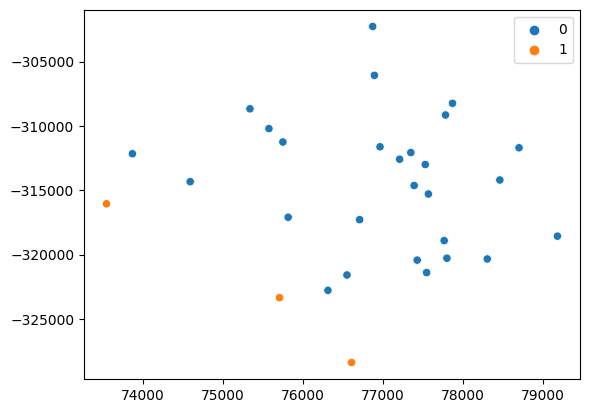

In [111]:
import seaborn as sns

sns.scatterplot(y=[-x.personal_best_score.profit for x in pso.particles],x=[x.personal_best_score.time for x in pso.particles],hue=dominance_flags)